# STILL NONSENSE TESTING - IGNORE 

In [88]:
%load_ext autoreload
%autoreload 2
from scipy import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from braincoder.utils.visualize import *
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Simulate data

In [89]:
import prfpy_csenf
import os 
from os.path import join as opj
seq_path = os.path.join(os.path.dirname(prfpy_csenf.__path__[0]))
sfs_seq = np.load(opj(seq_path, 'eg_sfs_seq.npy'))
# sfs_seq = np.append(sfs_seq, np.zeros(500))

con_seq = np.load(opj(seq_path, 'eg_con_seq.npy'))
# con_seq = np.append(con_seq, np.zeros(500))
paradigm = np.vstack([sfs_seq, con_seq])


In [98]:
SF_levels = [ 0.5,  1.,   3.,   6.,  12.,  18. ] 

def create_sequence(n_c_steps, n_c_rep, **kwargs):
    # we want blank down-SF1, up-SF2, blank, ...
    SF_list = [3, 18, 1, 6, 0.5, 12, 6, 1, 12, 3, 18, 0.5] # pseudo random...
    con_list = np.repeat(
        np.logspace(np.log10(0.25), np.log10(80), n_c_steps),
        n_c_rep
        )
    con_list = [i for i in con_list]
    n_blanks = kwargs.get('n_blanks', 10)

    sf_seq = []
    con_seq = []
    i_TYPE = 0
    while len(SF_list) > 0:
        if i_TYPE == 0:
            # Blanks
            sf_seq += [0] * n_blanks
            con_seq += [0] * n_blanks
        elif i_TYPE == 1:
            # DOWN
            this_SF = SF_list.pop(0)
            sf_seq += [this_SF] * len(con_list)
            con_seq += con_list[::-1]
        elif i_TYPE == 2:
            # UP
            this_SF = SF_list.pop(0)
            sf_seq += [this_SF] * len(con_list)
            con_seq += con_list
            i_TYPE = -1
        i_TYPE += 1
    sf_seq += [0] * n_blanks
    con_seq += [0] * n_blanks
    paradigm = pd.DataFrame({
        'SF' : sf_seq,
        'CON' : con_seq,
    }).astype('float32')
    p = {
        'sf_seq' : sf_seq,
        'con_seq' : con_seq,
        'paradigm' : paradigm,
    }

    return paradigm #np.vstack([sf_seq, con_seq])

def create_sequence_with_sf_levels(n_c_steps, n_c_rep, sf_levels=SF_levels, **kwargs):
    # Using provided SF_levels or default ones
    SF_list = sf_levels.copy()
    np.random.shuffle(SF_list)  # randomly shuffle the SF levels
    
    con_list = np.repeat(
        np.logspace(np.log10(0.25), np.log10(80), n_c_steps),
        n_c_rep
        )
    con_list = [i for i in con_list]
    n_blanks = kwargs.get('n_blanks', 10)

    sf_seq = []
    con_seq = []
    i_TYPE = 0
    while len(SF_list) > 0:
        if i_TYPE == 0:
            # Blanks
            sf_seq += [0] * n_blanks
            con_seq += [0] * n_blanks
        elif i_TYPE == 1:
            # DOWN
            this_SF = SF_list.pop(0)
            sf_seq += [this_SF] * len(con_list)
            con_seq += con_list[::-1]
        elif i_TYPE == 2:
            # UP
            this_SF = SF_list.pop(0)
            sf_seq += [this_SF] * len(con_list)
            con_seq += con_list
            i_TYPE = -1
        i_TYPE += 1
    sf_seq += [0] * n_blanks
    con_seq += [0] * n_blanks
    paradigm = pd.DataFrame({
        'SF' : sf_seq,
        'CON' : con_seq,
    }).astype('float32')

    return paradigm
mstim = {}
mstim['S07'] = create_sequence(7, 3)
mstim['S14'] = create_sequence(40, 1)
# mstim['S7B20'] = create_sequence(7, 1, n_blanks=20)
stim_vers = list(mstim.keys())

In [99]:
# Stimulus object 
from braincoder.stimuli import ContrastSensitivityStimulus
cs_stim = ContrastSensitivityStimulus()

In [100]:
bounds = {
    'width_r'  : [0,1.5],          
    'SFp'       : [0, 6],
    'CSp'       : [0, 200] ,
    'width_l'   : [0.68, 0.68],     # we fix width_l in our model
    'crf_exp'   : [0, 5] ,
    'amplitude' : [0, 10],       # Amplitude of TC
    'baseline'  : [-2,2]
}
n_vx = 100
parameters = pd.DataFrame({
    key:np.random.uniform(bounds[key][0], bounds[key][1], n_vx) for key in bounds
}).astype('float32')

n_vx = parameters.shape[0]
idx_cols = sns.color_palette("hsv", n_vx)

In [101]:
from braincoder.models import ContrastSensitivity, ContrastSensitivityWithHRF
from braincoder.hrf import SPMHRFModel, CustomHRFModel, HRFModel

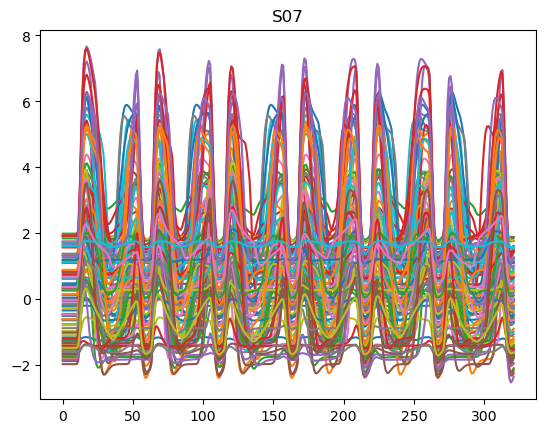

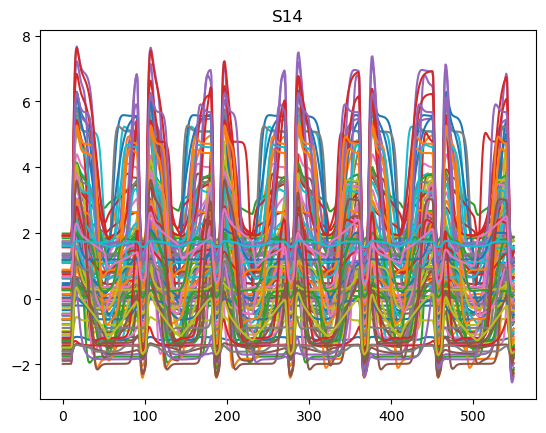

In [102]:
model = ContrastSensitivityWithHRF(
    parameters=parameters,
    hrf_model=SPMHRFModel(tr=1.5),
)
pred = {}
for s in stim_vers:
    pred[s] = model.predict(
        paradigm=mstim[s],
    )
    plt.figure()
    plt.title(s)
    plt.plot(pred[s])

# Classic fitter

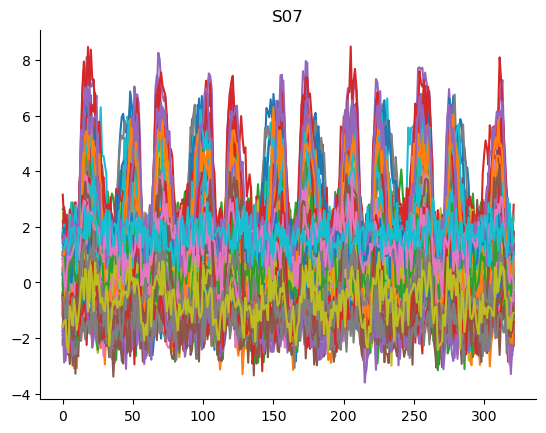

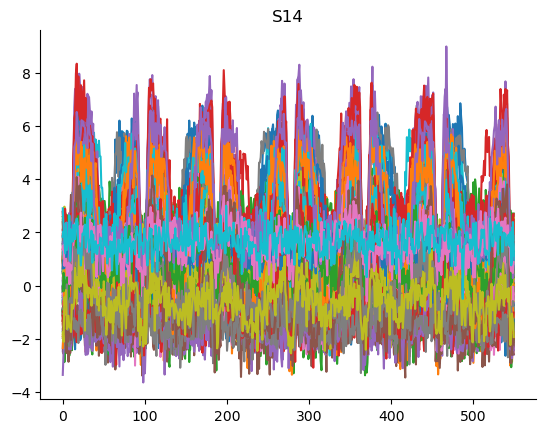

In [103]:
data = {}
for s in stim_vers:
    data[s] = model.simulate(noise=.5, paradigm=mstim[s])
    plt.figure()
    plt.title(s)    
    plt.plot(data[s])
    sns.despine()
        

In [104]:
from braincoder.bprf_mcmc import *
from braincoder.optimize import ParameterFitter
cfitter = {}
refined_pars = {}
for s in stim_vers:
    cfitter[s] = ParameterFitter(model, data[s], mstim[s])
    grid_pars = cfitter[s].fit_grid(
        width_r     =np.linspace(bounds['width_r'][0], bounds['width_r'][1], 5),
        SFp         =np.linspace(bounds['SFp'][0], bounds['SFp'][1], 5),
        CSp         =np.linspace(bounds['CSp'][0], bounds['CSp'][1], 10),
        width_l     =np.linspace(bounds['width_l'][0], bounds['width_l'][1], 5),
        crf_exp     =np.linspace(bounds['crf_exp'][0], bounds['crf_exp'][1], 5),
        amplitude   =[1.0],
        baseline    =[0],
        use_correlation_cost=True
    )
    ols_pars = cfitter[s].refine_baseline_and_amplitude(grid_pars)
    refined_pars[s] = cfitter[s].fit(init_pars=ols_pars, ) #fixed_pars={'width_l' : 0.68})

Working with chunk size of 3450
Using correlation cost!


100%|██████████| 2/2 [00:00<00:00,  5.46it/s]
/Users/marcusdaghlian/programs/braincoder_bprf/braincoder/optimize.py:420: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.14426100e+00 6.16755819e+00 2.20127726e+00 2.90243745e+00
 4.09378242e+00 8.03031445e+00 4.86207771e+00 5.81772757e+00
 5.00915718e+00 6.21913052e+00 9.02524281e+00 3.92499256e+00
 1.42004871e+00 1.00000000e-04 4.66541624e+00 3.33863235e+00
 6.12655103e-01 9.36455059e+00 7.68053150e+00 3.22366619e+00
 3.65423113e-01 1.00000000e-04 3.87057996e+00 1.41156077e+00
 8.72012424e+00 1.69379520e+00 3.26319838e+00 2.78385472e+00
 3.04996848e+00 3.45261002e+00 1.90310180e-01 1.60972404e+00
 5.37257481e+00 2.49524641e+00 9.22061157e+00 3.00483441e+00
 2.72545069e-01 4.14343566e-01 4.93645811e+00 3.08317327e+00
 8.92450047e+00 7.26805353e+00 6.45391583e-01 8.12927532e+00
 9.29472160e+00 4.75343180e+00 6.10676813e+00 1.56190264e+00
 1.64799869e+00 6.

Number of problematic voxels (mask): 0
Number of voxels remaining (mask): 100


Current R2: nan/Best R2: 0.61462: 100%|██████████| 1000/1000 [00:08<00:00, 118.38it/s]


Working with chunk size of 2020
Using correlation cost!


100%|██████████| 4/4 [00:00<00:00, 10.13it/s]
/Users/marcusdaghlian/programs/braincoder_bprf/braincoder/optimize.py:420: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.33939171e+00 6.24914408e+00 1.91642439e+00 2.59863091e+00
 4.26029682e+00 8.18073273e+00 4.89244270e+00 6.00161552e+00
 5.62318182e+00 6.41528320e+00 9.25654411e+00 4.47279453e+00
 1.68369281e+00 3.84545743e-01 4.70533037e+00 3.43387604e+00
 6.05355799e-01 9.49430847e+00 7.88777590e+00 3.18018961e+00
 1.54284358e-01 1.00000000e-04 4.04221916e+00 1.58900142e+00
 8.92062283e+00 1.67882097e+00 3.24168706e+00 2.94215250e+00
 3.18493938e+00 3.94266224e+00 7.99420476e-02 1.47355175e+00
 5.82121325e+00 2.49614167e+00 9.62001896e+00 2.83678985e+00
 8.70512277e-02 2.19819397e-01 5.02574205e+00 3.14935637e+00
 8.88812733e+00 7.46386576e+00 7.47045577e-01 9.08309746e+00
 9.48213100e+00 4.89111900e+00 6.79690933e+00 1.62027502e+00
 1.32933378e+00 6.

Number of problematic voxels (mask): 0
Number of voxels remaining (mask): 100


Current R2: nan/Best R2: 0.60584: 100%|██████████| 1000/1000 [00:10<00:00, 92.93it/s] 


/Users/marcusdaghlian/miniforge3/envs/braincoder/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/marcusdaghlian/miniforge3/envs/braincoder/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/var/folders/01/hhsk37310zsgzgg1nhgs6rfm0000gn/T/ipykernel_54059/3402291142.py:20: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(bounds[param])
/var/folders/01/hhsk37310zsgzgg1nhgs6rfm0000gn/T/ipykernel_54059/3402291142.py:21: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(bounds[param])


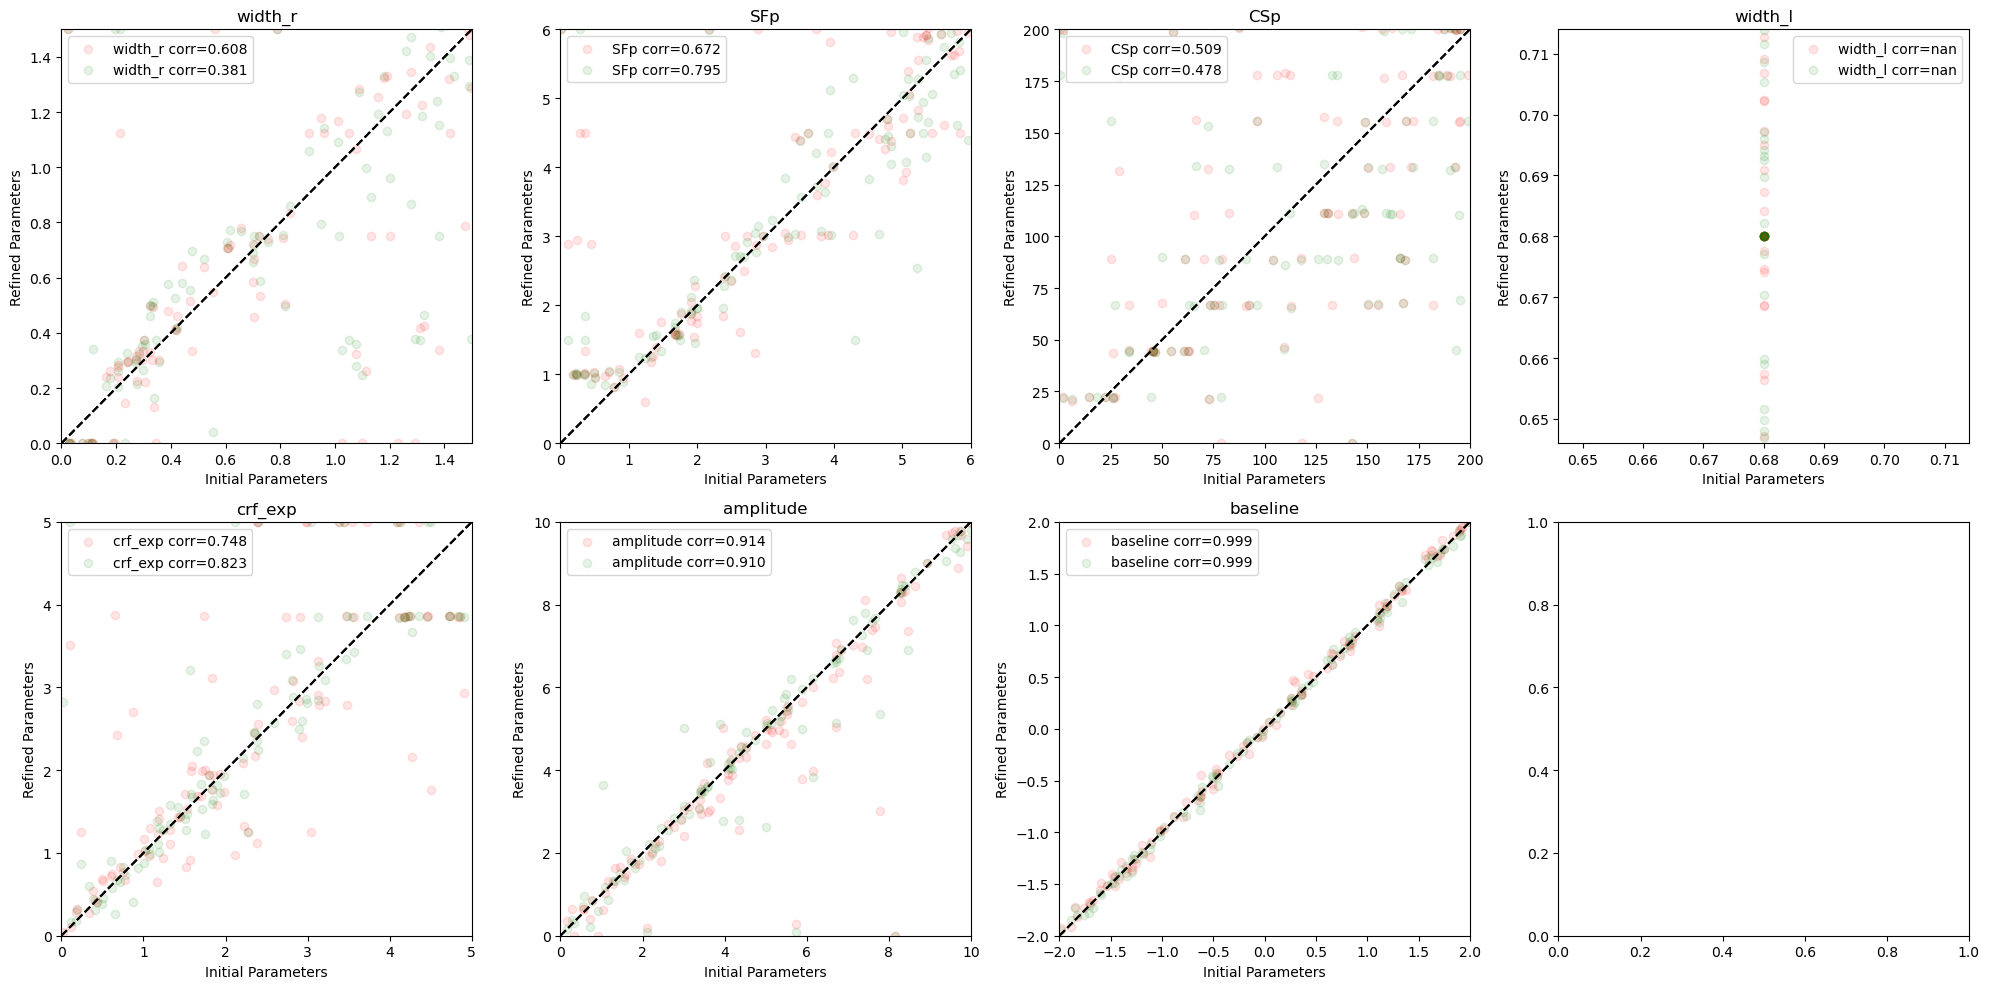

In [106]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
axs = axs.flatten()
param_names = parameters.columns
s_cols = ['r', 'g', 'b']
for iS,s in enumerate(stim_vers):
    for i, param in enumerate(param_names):
        ax = axs[i]
        corr = np.corrcoef(parameters[param], refined_pars[s][param])[0, 1]
        ax.scatter(
            parameters[param], 
            refined_pars[s][param], 
            c = s_cols[iS],
            label=f'{param} corr={corr:.3f}',
            alpha=0.1)
        ax.set_title(f'{param}')  
        ax.set_xlabel('Initial Parameters')
        ax.set_ylabel('Refined Parameters')
        ax.plot([bounds[param][0], bounds[param][1]], 
                [bounds[param][0], bounds[param][1]], 'k--')
        ax.set_xlim(bounds[param])
        ax.set_ylim(bounds[param])
        # ax.set_aspect('square')
        ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
m = 'S07'
this_model = ContrastSensitivityWithHRF(
    data=data[m],
    hrf_model=SPMHRFModel(tr=1.5),
    SF_seq=mstim['S28']['SF'],
    CON_seq=mstim['S28']['CON'],
)
bfitter = BPRF(this_model, data['S28'])
bfitter.add_priors_from_bounds(
    bounds, 
)
bfitter.prep_for_fitting()


init_pars = {
    'width_r' : np.ones(n_vx) * 1,
    'SFp' : np.ones(n_vx) * 1,
    'CSp' : np.ones(n_vx) * 100,
    'width_l' : np.ones(n_vx) * 0.68,
    'crf_exp' : np.ones(n_vx) * 1,
    'amplitude' : np.ones(n_vx) * 1, 
    'baseline' : np.ones(n_vx) * 0, 
}
init_pars = pd.DataFrame(init_pars)

idx=0
bfitter.fit_all(
    init_pars=init_pars, 
    num_results=100,
    # paradigm = mstim['S28']
)

KeyError: 'S28'

In [73]:
bfitter.mcmc_sampler[0]

,width_r,SFp,CSp,width_l,crf_exp,amplitude,baseline
0,1.0,1.0,100.0,0.68,1.0,1.0,0.0
1,1.0,1.0,100.0,0.68,1.0,1.0,0.0
2,1.0,1.0,100.0,0.68,1.0,1.0,0.0
3,1.0,1.0,100.0,0.68,1.0,1.0,0.0
4,1.0,1.0,100.0,0.68,1.0,1.0,0.0
...,...,...,...,...,...,...,...
145,1.0,1.0,100.0,0.68,1.0,1.0,0.0
146,1.0,1.0,100.0,0.68,1.0,1.0,0.0
147,1.0,1.0,100.0,0.68,1.0,1.0,0.0
148,1.0,1.0,100.0,0.68,1.0,1.0,0.0


In [ ]:
idx = 3
burn_in = 100
plt.plot(data.iloc[:,0], ':k')
plt.plot(pred.iloc[:,0], ':r')
cpred = model.predict(parameters=refined_pars)
plt.plot(cpred.iloc[:,idx], 'b')
# this_pred = bfitter.model.predict(
#     parameters=bfitter.mcmc_sampler[idx]
# )
# plt.plot(
#     this_pred.iloc[:,burn_in:], '-g', alpha=.1,
# )

In [ ]:
# Lets see are we getting closer?
fig,axs = plt.subplots(2,4,figsize=(20,10))
axs = axs.flatten()
for ip,p in enumerate(bfitter.model_labels):
    ax = axs[ip]
    ax.set_title(p)
    ax.set_xlabel('Step in MCMC chain')
    for i in range(n_vx):
        ax.plot(
            bfitter.mcmc_sampler[i][p] - parameters[p][i],
            color=idx_cols[i],        
            )
        # # Lets add the ground truth
        # ax.axhline(
        #     parameters[p][i], 
        #     color=idx_cols[i],        
        #     linestyle=':'
        # )

ax = axs[-1]
ax.set_title('Rsq')
for i in range(n_vx):
    rsq = bfitter.get_rsq_for_idx(
        idx=i, parameters=bfitter.mcmc_sampler[i],
    )
    plt.plot(
        rsq, 
        color=idx_cols[i]
        ) 
plt.ylim(0,1)
plt.tight_layout()

In [ ]:
bfitter.mcmc_sampler[i][p] -  parameters[p][i]

In [ ]:
bfitter.mcmc_sampler[n_vx]

In [ ]:
rsq = fitter.get_rsq_for_idx(
    idx=idx, parameters=fitter.mcmc_sampler[idx],
)

rsq_cols = dag_get_col_vals(
    rsq, cmap='RdBu_r', vmin=-1, vmax=1,
    )
rsq


In [ ]:
plt.plot(rsq)

In [ ]:
pred = fitter.get_predictions(
    parameters=fitter.mcmc_sampler[idx],
    # c=rsq_cols[500:,:]
)
id_start = 540
colors = [tuple(color) for color in rsq_cols[id_start:, :-1]]
plt.plot(
    pred.iloc[:,id_start:],
    # c=colors,
)
plt.plot(data.iloc[:,0])
fitter.mcmc_sampler[idx].iloc[545:546,:]

In [ ]:
idx = 0
burn_in = 100
sns_plot = sns.pairplot(
    fitter.mcmc_sampler[idx].iloc[burn_in:,:],
    plot_kws={'color':rsq_cols[burn_in:,:]},
    # corner=True, 
    diag_kind='kde'
)
sns_plot.map_lower(sns.kdeplot, levels=4, color=0.2)
# sns_plot.

edit_pair_plot(
    sns_plot.axes, 
    lines_dict=parameters.iloc[idx,:].to_dict(), 
    lim_dict=bounds, 
    color='g', linestyle=':', lw=4, label='Truth'
)
# edit_pair_plot(
#     sns_plot.axes, init_pars.iloc[idx,:].to_dict(), color='c', linestyle=':', lw=4,
# )
# edit_pair_plot(
#     sns_plot.axes, refined_pars.iloc[idx,:].to_dict(), color='r', linestyle=':', lw=4,
# )
plt.legend()
plt.show()

In [ ]:
a = fitter.mcmc_sampler[1]
pred = model.predict(parameters=a.iloc[:1,:])

plt.plot(data.iloc[:,0])
plt.plot(pred)

In [ ]:
for p in a.keys():
    plt.figure()
    plt.plot(a[p])
    plt.title(p)

for p in a.keys():
    plt.figure()
    plt.hist(a[p])
    plt.title(p)    

In [24]:
fitter.mcmc_sampler[0]

In [ ]:
import corner as corner
_ = corner.corner(
    fitter.mcmc_sampler[1].iloc[500:,:],# truths=parameters.iloc[0,:].T
    # truths=parameters.iloc[1,:]
)
print(parameters.iloc[1,:])
# corner.overplot_points(
#     plt.gcf(), parameters.iloc[0,:],
# )

In [ ]:
pred = fitter.model.predict(
    parameters=fitter.mcmc_sampler[1].iloc[7483:7484,:]
)
pred.plot()
data.iloc[:,0].plot()

In [ ]:
fitter.mcmc_stats[1]['log_prob'].numpy().argmax()

In [ ]:
parameters.keys()
a.keys()

In [ ]:
parameters

In [ ]:
b = model.predict(parameters=a.iloc[:100,:])
plt.plot(b)
plt.plot(data.iloc[:,0], '--k')

In [ ]:
data.iloc[:,0]

In [ ]:
Code

In [ ]:
pars  = ols_pars.iloc[:,0].to_numpy()
pars = pars[np.newaxis,...]
model.predict(parameters = pars) #ols_pars.iloc[:,:0])

In [93]:
eg1 = a[0].numpy()
eg2 = a[1].numpy()

In [ ]:
plt.plot(eg1[:,0])
plt.plot(eg2[:,0])

In [ ]:
init_pars = model._get_parameters(ols_pars)
model._transform_parameters_backward(init_pars.values.astype(np.float32))
